In [1]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import threading
import warnings
from pathlib import Path
from typing import Optional
import psutil
import json

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import datasets
import diffusers
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available
from huggingface_hub import HfFolder, Repository, whoami
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig, CLIPFeatureExtractor
from peft import LoraModel, LoraConfig, get_peft_model_state_dict, set_peft_model_state_dict

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.10.0.dev0")

logger = get_logger(__name__)


MODEL_NAME = "CompVis/stable-diffusion-v1-4"  # "stabilityai/stable-diffusion-2-1-base"
INSTANCE_PROMPT = "a photo of sks dog"
ckpt_dir = "/home/sourab/temp/sd_dog_dreambooth/"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to("cuda")

prompt = "a photo of sks dog"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

In [3]:
def load_and_set_lora_ckpt(pipe, ckpt_dir, instance_prompt, device, dtype):
    with open(f"{ckpt_dir}{instance_prompt}_lora_config.json", "r") as f:
        lora_config = json.load(f)
    print(lora_config)

    checkpoint = f"{ckpt_dir}{instance_prompt}_lora.pt"
    lora_checkpoint_sd = torch.load(checkpoint)
    unet_lora_ds = {k: v for k, v in lora_checkpoint_sd.items() if "text_encoder_" not in k}
    text_encoder_lora_ds = {
        k.replace("text_encoder_", ""): v for k, v in lora_checkpoint_sd.items() if "text_encoder_" in k
    }

    unet_config = LoraConfig(**lora_config["peft_config"])
    pipe.unet = LoraModel(unet_config, pipe.unet)
    set_peft_model_state_dict(pipe.unet, unet_lora_ds)

    if "text_encoder_peft_config" in lora_config:
        text_encoder_config = LoraConfig(**lora_config["text_encoder_peft_config"])
        pipe.text_encoder = LoraModel(text_encoder_config, pipe.text_encoder)
        set_peft_model_state_dict(pipe.text_encoder, text_encoder_lora_ds)

    if dtype in (torch.float16, torch.bfloat16):
        pipe.unet.half()
        pipe.text_encoder.half()

    pipe.to(device)
    return pipe


pipe = load_and_set_lora_ckpt(pipe, ckpt_dir, INSTANCE_PROMPT, "cuda", torch.float16)

{'pet_config': {'pet_type': 'LORA', 'task_type': None, 'inference_mode': True, 'r': 16, 'target_modules': ['to_q', 'to_v', 'query', 'value'], 'lora_alpha': 27, 'lora_dropout': 0.0, 'merge_weights': False, 'fan_in_fan_out': False, 'enable_lora': None, 'bias': 'none'}, 'text_encoder_pet_config': {'pet_type': 'LORA', 'task_type': None, 'inference_mode': True, 'r': 16, 'target_modules': ['q_proj', 'v_proj'], 'lora_alpha': 17, 'lora_dropout': 0.0, 'merge_weights': False, 'fan_in_fan_out': False, 'enable_lora': None, 'bias': 'none'}}


In [ ]:
prompt = "a photo of sks dog"
negative_prompt = "low quality, blurry, unfinished"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

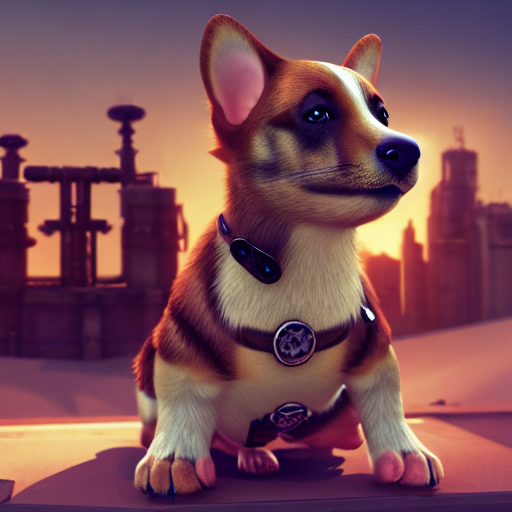

In [24]:
prompt = "sks dog in a steampunk city, 4K render, trending on artstation, masterpiece"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, negative_prompt=negative_prompt).images[0]
image

In [ ]:
prompt = "sks dog with Eiffel Tower in the background"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, negative_prompt=negative_prompt).images[0]
image

In [ ]:
prompt = "sks dog swimming in th pool with sunglasses"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, negative_prompt=negative_prompt).images[0]
image

In [ ]:
prompt = "sks dog weaing red sweater"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5, negative_prompt=negative_prompt).images[0]
image